In [19]:
import numpy
from etrade.spot.trader import Station
from etrade.spot.market.recycle import BasicRecycle, PointwiseRecycle
from etrade.spot.forecast.market import DistributiveSeries, DistributiveMarket
from etrade.spot.forecast.plan_a.constructor import *
from etrade.spot.forecast.plan_a.transformer import MarketSampleTransformer, MarketSampleDataset
from etrade.spot.forecast.yieldindex import zero_quantile
from etrade.spot.forecast import yieldindex
from  data_utils.stochastic_utils.vdistributions.abstract import AbstractDistribution
from  data_utils.stochastic_utils.vdistributions.parameter.continuous.basic import NormalDistribution, SkewNormalDistribution
from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.kernel2 import KernelMixDistribution
from data_utils.stochastic_utils.vdistributions.tools.divergence import kl_divergence_continuous, crps, quantile_RMSE

from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.mfk.skewnd2 import dof_snd_fitter

from scipy.optimize import differential_evolution

from matplotlib import pyplot
import json

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [20]:

with open(r"..\forecast\plan_a\data\market_simulator_3.json", "r") as f:
    train_data = json.loads(f.read())
    
with open(r"..\forecast\plan_a\data\market_simulator_4.json", "r") as f:
    test_data = json.loads(f.read())

In [21]:
train_data =numpy.asarray(train_data["data"])
test_data =numpy.asarray(test_data["data"])

In [22]:
train_data[0]

array([  3.74631481,   4.29589058,   2.10662714,  22.18100685,
        24.74928446,  27.20674001,  33.51675293,  40.14512051,
        -8.4606474 ,   2.42573414,   6.08898855,   9.35027419,
        20.93346565,  -9.83276561,   2.0368428 ,   5.23280401,
         8.21498886,  18.46201281, -65.57496741,  -5.28906343,
        51.15490511, 122.69519891, 188.44048472, 258.47401496,
       317.421107  , 387.5387652 , 475.20540052, -71.7962162 ])

In [23]:
market_len = 1
# l = 3 * market_len + market_len
l = market_len * 3 + market_len * (5-0) * 3 + 9
def zscore_p(x):
    x = numpy.asarray(x)
    m = numpy.mean(x, axis=0)
    s = numpy.std(x, ddof=1, axis=0)
    return m,s

def zscore(x, m, s):
    x = numpy.asarray(x)
    m = numpy.asarray(m)
    s = numpy.asarray(s)
    # return numpy.column_stack((
    #         (x[:,:l]-m[:l]) / s[:l], x[:,l]
    # ))
    return (x-m) / s

def minmax_p(x):
    x = numpy.asarray(x)
    mmax = numpy.max(x, axis=0)
    mmin = numpy.min(x, axis=0)
    return mmin, mmax

def minmax(x, mmin, mmax):
    x = numpy.asarray(x)
    mmin = numpy.asarray(mmin)
    mmax = numpy.asarray(mmax)
    return (x-mmin) / (mmax-mmin)
    # return numpy.column_stack((
    #         (x[:,:l]-mmin[:l]) / (mmax[:l]-mmin[:l]), x[:,l]
    # ))
    
print(l)
    

27


In [24]:
m,s= zscore_p(train_data)
zscored_t = zscore(train_data, m, s)
zscored_x = zscore(test_data, m, s)

mmin,mmax = minmax_p(train_data)
minmaxed_t = minmax(train_data, mmin, mmax)
minmaxed_x = minmax(test_data, mmin, mmax)

print(zscored_t.shape)

(3000, 28)


In [25]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
p = MLPRegressor(
    hidden_layer_sizes=[50] * 4,
    activation="relu",
    solver="lbfgs",
    # alpha=1e-3,
    # learning_rate_init=1e-3
)
# p = RandomForestRegressor(
#     # alpha=0.999
# )
# p = SVR(
#     # alpha=1
# )
p.fit(
    zscored_t[:,:l],
    zscored_t[:,l]
)

C:\Users\sangsiyuan\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(hidden_layer_sizes=[50, 50, 50, 50], solver='lbfgs')

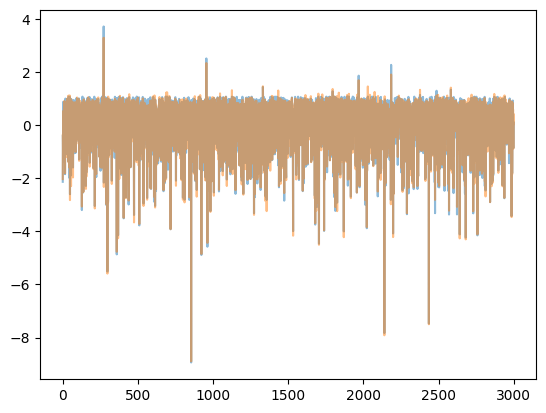

In [26]:

pyplot.plot(zscored_t[:,l], alpha=0.5)
pyplot.plot(p.predict(zscored_t[:,:l]), alpha=0.5)

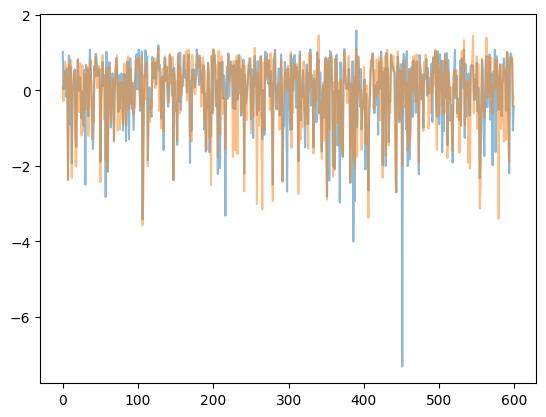

In [27]:

pyplot.plot(zscored_x[:,l], alpha=0.5)
pyplot.plot(p.predict(zscored_x[:,:l]), alpha=0.5)

In [28]:
p.score(zscored_x[:,:l], zscored_x[:,l])

0.6314213200022203

In [29]:
p.score(zscored_t[:,:l], zscored_t[:,l])

0.9697156292847721

In [30]:
numpy.corrcoef(p.predict(zscored_x[:,:l]), zscored_x[:,l])

array([[1.        , 0.81128816],
       [0.81128816, 1.        ]])

In [31]:
model = MarketSampleTransformer(l, 128, 4, 2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.SmoothL1Loss()
criterion = nn.MSELoss()

C:\Users\sangsiyuan\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [32]:
batch_size = 600
epoch_size = 200

zscored_t_dataset = MarketSampleDataset(zscored_t)
train_loader = DataLoader(zscored_t_dataset, batch_size=batch_size, shuffle=True)

zscored_x_dataset = MarketSampleDataset(zscored_x)
test_loader = DataLoader(zscored_x_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epoch_size):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        # batch_x, batch_y = batch_x, batch_y
        optimizer.zero_grad()
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            # batch_x, batch_y = batch_x, batch_y
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
            test_loss += loss.item() * batch_x.size(0)
    avg_test_loss = test_loss / len(test_loader.dataset)

    print(f"Epoch {epoch+1}/{epoch_size} | Train Loss: {avg_loss:.6f} | Test Loss: {avg_test_loss:.6f}")

Epoch 1/200 | Train Loss: 2.218716 | Test Loss: 1.341302
Epoch 2/200 | Train Loss: 1.161160 | Test Loss: 0.837221
Epoch 3/200 | Train Loss: 0.920286 | Test Loss: 0.769211
Epoch 4/200 | Train Loss: 0.809444 | Test Loss: 0.667366
Epoch 5/200 | Train Loss: 0.688613 | Test Loss: 0.644649
Epoch 6/200 | Train Loss: 0.613697 | Test Loss: 0.602510
Epoch 7/200 | Train Loss: 0.568667 | Test Loss: 0.566359
Epoch 8/200 | Train Loss: 0.521619 | Test Loss: 0.525218
Epoch 9/200 | Train Loss: 0.469058 | Test Loss: 0.489284
Epoch 10/200 | Train Loss: 0.425165 | Test Loss: 0.455936
Epoch 11/200 | Train Loss: 0.399682 | Test Loss: 0.433528
Epoch 12/200 | Train Loss: 0.370602 | Test Loss: 0.394025
Epoch 13/200 | Train Loss: 0.345866 | Test Loss: 0.385025
Epoch 14/200 | Train Loss: 0.330564 | Test Loss: 0.370076
Epoch 15/200 | Train Loss: 0.315833 | Test Loss: 0.364722
Epoch 16/200 | Train Loss: 0.297987 | Test Loss: 0.367138
Epoch 17/200 | Train Loss: 0.280068 | Test Loss: 0.347294
Epoch 18/200 | Train Lo

In [33]:
model.eval()
all_preds = []
all_targets = []
# 拿一批数据来预测
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        preds = model(batch_x)
        all_preds.append(preds)    # 收集预测结果
        all_targets.append(batch_y)  # 收集真实标签
        
all_preds = torch.cat(all_preds, dim=0).numpy()     # (400,)
all_targets = torch.cat(all_targets, dim=0).numpy() # (400,)

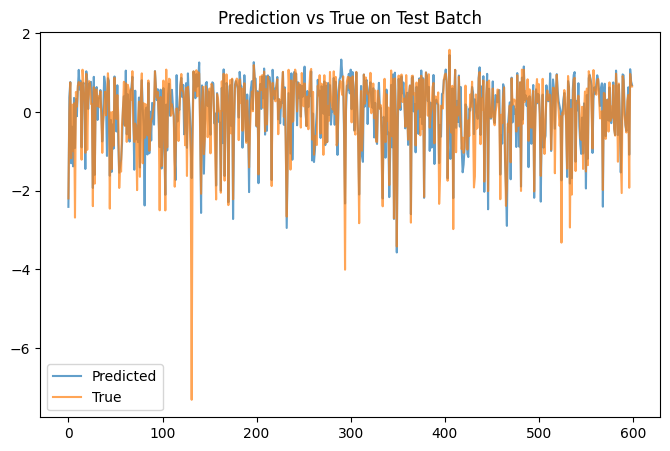

In [34]:
pyplot.figure(figsize=(8,5))
pyplot.plot(all_preds, label="Predicted", alpha=0.7)
pyplot.plot(all_targets, label="True", alpha=0.7)
pyplot.legend()
pyplot.title("Prediction vs True on Test Batch")
pyplot.show()

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_absolute_error(all_targets, all_preds)
print(f"Test MSE on 600 samples: {mse:.6f}")

Test MSE on 600 samples: 0.310429


In [36]:
from sklearn.metrics import r2_score
r2 = r2_score(all_targets, all_preds)
print(f"Test R^2 on 600 samples: {r2:.6f}")

Test R^2 on 600 samples: 0.735633
